<h1><b>*TP5*: Consultas Elasticsearch y Visualización de datos: <br>
1. <br>
1.1 ¿Cuántos tweets tienen la palabra "liverpool"? <br>
1.2 ¿Cómo se distribuye los tweets en el tiempo (ver en un histograma)<br>
2. ¿De dónde vienen los tweets? (utilizar el campo 'location')<br>
3. ¿Cuántos tweets tienen las palabras "liverpool" y "goal"? (ver en un histograma)<br>
4. Graficar un Pie Chart comparando el número de tweets con: a) la palabra 'liverpool', b) la palabra 'madrid', c) la palabra 'madrid' y 'liverpool' d) ninguna de las palabras<br>
5. ¿Cuáles son los emoticons más frecuentes? A partir de las visualizaciones disponibles en las librerias MatplotLib y/o Seaborn (seaborn.pydata.org), proponer una visualización para observar las emociones expresadas durante el partido<br>

In [1]:
import pandas as pd

<h1><b>1.1 ¿Cuántos tweets tienen la palabra "liverpool"? <br>



In [2]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch()

if not(es.indices.exists(index="tp5-romero")):
    res = es.indices.create(index="tp5-romero")  
    pprint(res)

In [3]:
#LISTAR LOS ARCHIVOS DEL DATASET
import json
import os
files = os.listdir("dataset_tp5_romero")
pprint(len(files))

354585


In [ ]:
from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('dataset_tp5_romero/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            timestamp=int(tweet["timestamp_ms"])
            #pprint(tweet)
            simple_tweet = {
                "timestamp":timestamp, \
                "date":tweet["created_at"], \
               "text": tweet['text'], \
               "username": tweet['user']['name'], \
               "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)#remove comment
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="tp5-romero", doc_type="_doc")
        tweets=[]

In [119]:
es = Elasticsearch()

res = es.search(index="tp5-romero", body={"query" : { "match" : { "text" : "liverpool" }
      }})
print("Got %d Hits:" % res['hits']['total'])

Got 44034 Hits:


<b>RESPUESTA: 44034 TWEETS TIENEN LA PALABRA "liverpool"

<h1><b>1.2 ¿Cómo se distribuye los tweets en el tiempo (ver en un histograma)

In [ ]:
#CONSULTA: ¿Cuántos tweets cada minuto?
res = es.search(index="tp5-romero", body={"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
for data in res['aggregations']['tweets_over_time']['buckets']:
    print(data['doc_count'])

In [8]:
tweets = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
tweets = tweets.rename(columns={'key': 'hora', 'doc_count': 'numero_tweets'})
tweets[:10]

,numero_tweets,hora
0,38,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000
5,0,1527340980000
6,0,1527341040000
7,0,1527341100000
8,0,1527341160000
9,0,1527341220000


In [9]:
import datetime

def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

tweets['hora']=tweets['hora'].apply(timestamp2date)
tweets[:10]

,numero_tweets,hora
0,38,09:18:00
1,0,09:19:00
2,0,09:20:00
3,0,09:21:00
4,0,09:22:00
5,0,09:23:00
6,0,09:24:00
7,0,09:25:00
8,0,09:26:00
9,0,09:27:00


<B>RESPUESTA:

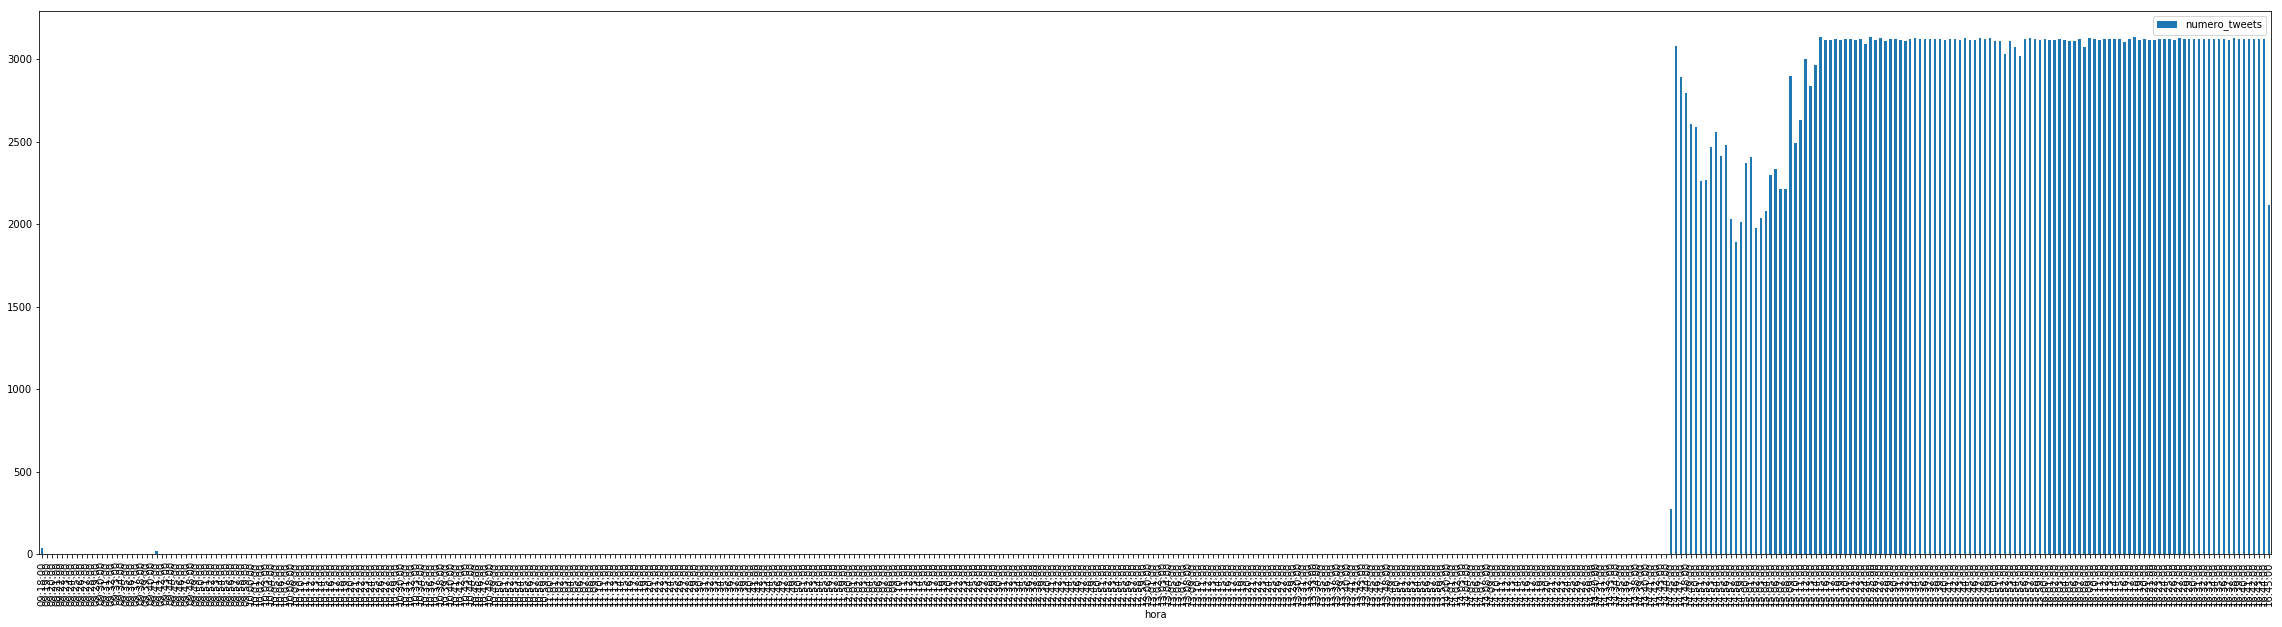

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

tweets.plot(kind='bar',figsize=(40,10), fontsize=10, x='hora')
plt.show()

<h1><b>2) ¿De dónde vienen los tweets? (utilizar el campo 'location')<br>



<b>RESPUESTA:

In [15]:
res = es.search(index="tp5-romero", body={"query": {"match_all": {}}})
print("Got %d Hits:" % res['hits']['total'])
for data in res['hits']['hits']:
    print("%(location)s" % data["_source"])

Got 354000 Hits:
Instagram arachelisfcb
None
None
Temuco, Chile
None
None
Caernarfon / Bangor
Las Palmas de Gran Canaria
 Mansoura..Egypt
Lima, Perú


<h1><b>3. ¿Cuántos tweets tienen las palabras "liverpool" y "goal"? (ver en un histograma)<br>



In [126]:
es = Elasticsearch()

res = es.search(index="tp5-romero", body={"query": {
        "match": {
            "text": {      
                "query":    "liverpool goal!",
                "operator": "and"
            }
        }
    }})
print("Got %d Hits:" % res['hits']['total'])
d = {'evento': [1] , 'tweets_liverpool_goal': [ "%d" % res['hits']['total']]}
df = pd.DataFrame(data=d)
df

Got 1666 Hits:


,evento,tweets_liverpool_goal
0,1,1666


<b>RESPUESTA

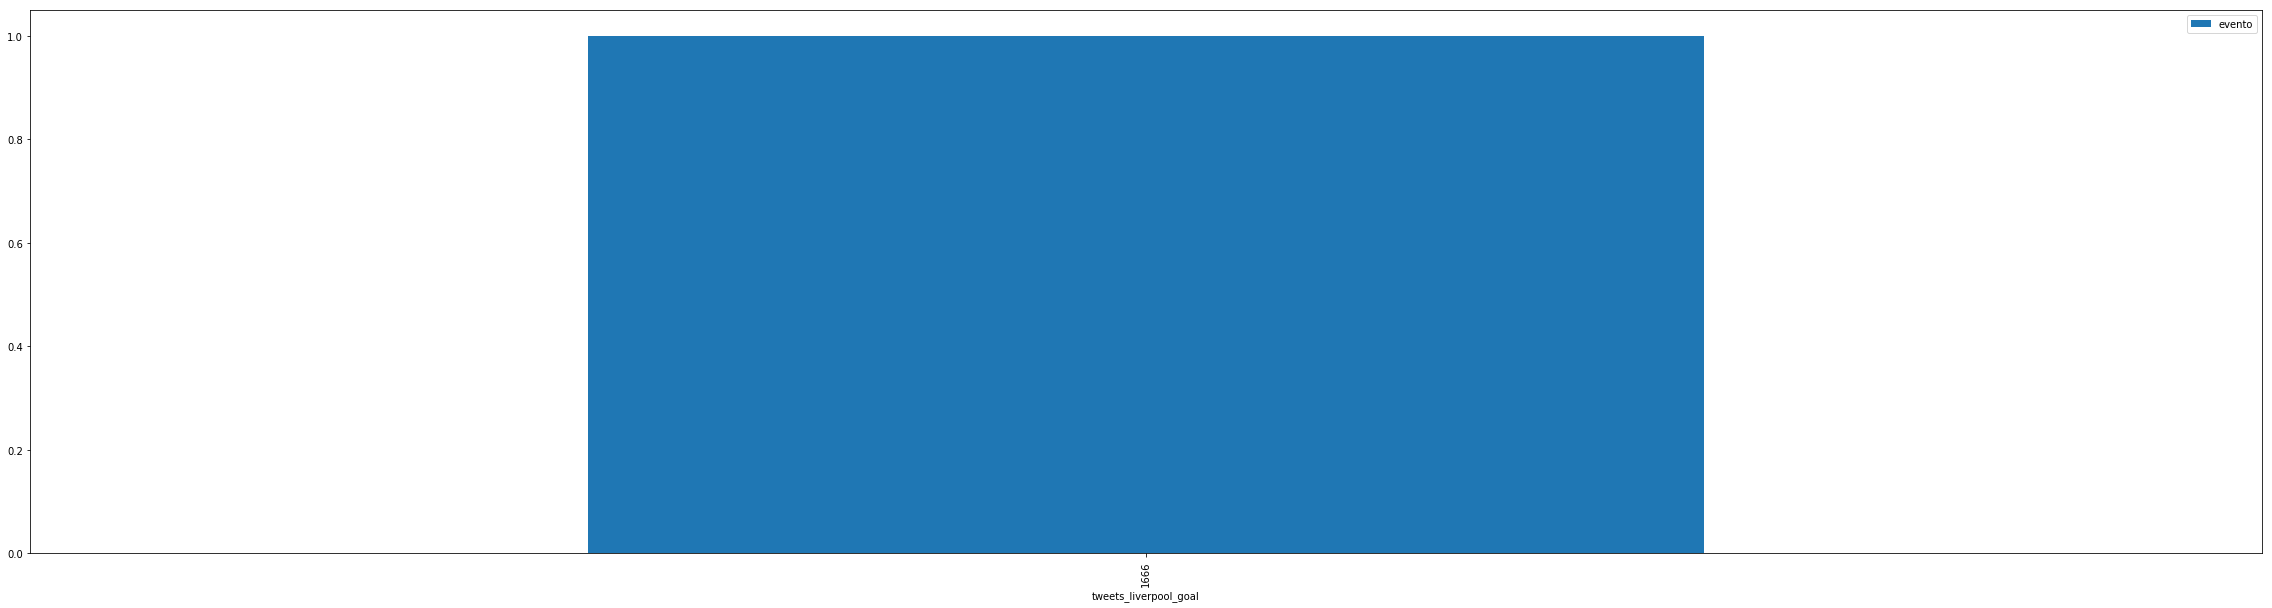

In [76]:
df.plot(kind='bar',figsize=(40,10), fontsize=10, x='tweets_liverpool_goal')
plt.show()

<h1><b>4. Graficar un Pie Chart comparando el número de tweets con: a) la palabra 'liverpool', b) la palabra 'madrid', c) la palabra 'madrid' y 'liverpool' d) ninguna de las palabras<br>



<b>a. TWEETS CON LA PALABRA: liverpool

In [97]:
es = Elasticsearch()

res = es.search(index="tp5-romero", body={"query" : { "match" : { "text" : "liverpool" }
      }})
liverpool = int("%d" % res['hits']['total'])
print(liverpool)

44034


<b>b. TWEETS CON LA PALABRA: madrid

In [98]:
res = es.search(index="tp5-romero", body={"query" : { "match" : { "text" : "madrid" }
      }})
madrid = int("%d" % res['hits']['total'])
print(madrid)

32002


<b>c. TWEETS CON LA PALABRAS: madrid y liverpool

In [132]:
res = es.search(index="tp5-romero", body={"query": {
        "match": {
            "text": {      
                "query":    "liverpool madrid!",
                "operator": "and"
            }
        }
    }})
madliver = int("%d" % res['hits']['total'])
print(madliver)

15040


<b>d. TWEETS CON NINGUNA DE LAS PALABRAS

In [100]:
res = es.search(index="tp5-romero", body={"query": {
        "match": {
            "text": {      
                "query":    "liverpool madrid!",
                "operator": "or"
            }
        }
    }})
madliver_or = int("%d" % res['hits']['total'])
print(madliver_or)

60996


In [101]:
res = es.search(index="tp5-romero", body={"query": {"match_all": {}}})
all_tweets = int("%d" % res['hits']['total'])
print(all_tweets)

354000


In [102]:
ninguna = all_tweets - madliver_or
print(ninguna)

293004


<B>CREANDO EL PIE CHART

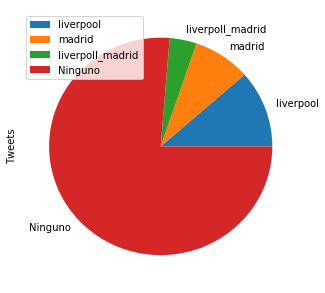

In [117]:
df = pd.DataFrame(    { 'Tweets': [liverpool, madrid ,madliver, ninguna]}  , index=['liverpool', 'madrid', 'liverpoll_madrid','Ninguno']     )
plot = df.plot.pie(y='Tweets', figsize=(5, 5))

<h1><b>5. ¿Cuáles son los emoticons más frecuentes? A partir de las visualizaciones disponibles en las librerias MatplotLib y/o Seaborn (seaborn.pydata.org), proponer una visualización para observar las emociones expresadas durante el partido<br>

<b>RESPUESTA: Según lo que leí en Internet, en Elasticsearch aún no existen las librerías para realizar un filtrado avanzado de emoticons. Si existiesen, podríamos agrupar los emogis por categorías. Ejemplos de estas categorías serían: Felicidad, Tristeza y Enojo. Utilizando las librerias de MatplotLib y estas categorías podríamos, en un PieChart mostrar cuales son las emociones expresadas durante el partido.